In [4]:
# === Cell 1 : Imports & TARGET selection ====================================
import os, re
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ---------------------------------------------------------------------------
# Configuration – **edit these if your folder layout changes**
# ---------------------------------------------------------------------------
# Root where all .npy files (or their sub‑folders) live
ARRIVAL_DIR = Path(r"C:\Users\samih\OneDrive - Imperial College London\Year 4\FYP\Sami Haque\Technical\Modding\Computer-Vision-for-Fire-Mod")

# Folder where averaged matrices will be written (created if missing)
AVERAGE_OUTDIR = ARRIVAL_DIR / "AVERAGED Arrival Matrices"
AVERAGE_OUTDIR.mkdir(exist_ok=True, parents=True)

# ---------------------------------------------------------------------------
# Put *either* individual .npy names *or* folder names inside TARGETS.
#   • If the entry has extension .npy  -> treated as a single file
#   • else it’s treated as a directory and every *.npy inside (non‑recursive)
#     will be added.
# ---------------------------------------------------------------------------
TARGETS = [
    # Example 1: one folder holding v1/v2/v3
    r"Sorted Arrival Matrices\Green Wool = Leaves",
    # Example 2: a single file somewhere else
    # r"Arrival Matrices\34 x 34--Green Wool = Leaves--v5 arrival.npy",
]

# ── helper to expand TARGETS into concrete file list ────────────────────────

def gather_matrix_files(root: Path, targets):
    files = []
    for entry in targets:
        p = (root / entry).resolve()
        if p.is_file():
            files.append(p)
        elif p.is_dir():
            files.extend(sorted(p.glob("*.npy")))
        else:
            print("⚠️  Not found:", p)
    # Return paths *relative* to root so captions remain tidy
    return [str(f.relative_to(root)) for f in files]

MATRIX_FILES = gather_matrix_files(ARRIVAL_DIR, TARGETS)

print("Found", len(MATRIX_FILES), "matrix file(s):")
for f in MATRIX_FILES:
    print(" •", f)

# Global isochrone spacing (sec)
TIME_INTERVAL = 10

# Average / save / show flags
COMPUTE_AVERAGE = True
SAVE_AVERAGE    = True
SHOW_ORIGINALS  = True
AVERAGE_NAME    = "Average of selected matrices"

Found 10 matrix file(s):
 • Sorted Arrival Matrices\Green Wool = Leaves\34 x 34--Green Wool = Leaves--v1 arrival.npy
 • Sorted Arrival Matrices\Green Wool = Leaves\34 x 34--Green Wool = Leaves--v10 arrival.npy
 • Sorted Arrival Matrices\Green Wool = Leaves\34 x 34--Green Wool = Leaves--v2 arrival.npy
 • Sorted Arrival Matrices\Green Wool = Leaves\34 x 34--Green Wool = Leaves--v3 arrival.npy
 • Sorted Arrival Matrices\Green Wool = Leaves\34 x 34--Green Wool = Leaves--v4 arrival.npy
 • Sorted Arrival Matrices\Green Wool = Leaves\34 x 34--Green Wool = Leaves--v5 arrival.npy
 • Sorted Arrival Matrices\Green Wool = Leaves\34 x 34--Green Wool = Leaves--v6 arrival.npy
 • Sorted Arrival Matrices\Green Wool = Leaves\34 x 34--Green Wool = Leaves--v7 arrival.npy
 • Sorted Arrival Matrices\Green Wool = Leaves\34 x 34--Green Wool = Leaves--v8 arrival.npy
 • Sorted Arrival Matrices\Green Wool = Leaves\34 x 34--Green Wool = Leaves--v9 arrival.npy


In [5]:
# === Cell 2 : Helper functions =============================================
PURPLE, GREEN, PINK           = (178,  69, 208), (  0,255,  0), (255,192,203)
LIGHTBLUE, DARKGREEN, WHITE  = (173,216,230), (  0, 90,  0), (255,255,255)


def _quad_rgb(y, x, h, w, mode):
    """Colour‑coding for NaN cells by quadrant."""
    top, left = y < h//2, x < w//2
    if mode == "quadrants-4":
        return (PURPLE if  top and  left else
                GREEN  if  top and not left else
                PINK   if not top and  left else
                LIGHTBLUE)
    if mode == "quadrants-3":
        return (PURPLE if left else
                GREEN  if top and not left else
                LIGHTBLUE)
    if mode == "quadrants-2":
        return PURPLE if left else GREEN
    if mode == "quadrants-1":
        return DARKGREEN
    return WHITE


def plot_arrival_heatmap_with_isochrones(arr,
                                         cmap="hot",
                                         time_interval=TIME_INTERVAL,
                                         *,
                                         unburnt_style="white",
                                         show_heatmap=True,
                                         show_isochrones=True,
                                         add_quadrant=True,
                                         caption=""):
    """Visualise a single arrival‑time matrix.

    • Optional heat‑map and/or blue isochrone contours
    • Colour‑bar height is locked to the image axes height
    • No title above the axes – instead, a caption is rendered below
    """
    data = arr[1:-1, 1:-1]  # strip outer border
    h, w = data.shape
    cx, cy = w//2, h//2
    finite = np.isfinite(data)
    t_min, t_max = np.nanmin(data), np.nanmax(data)

    # ── RGB canvas ----------------------------------------------------------
    rgb = np.full((h, w, 3), WHITE, np.uint8)
    if show_heatmap:
        norm = (data - t_min) / (t_max - t_min)
        heat = (cm.get_cmap(cmap)(norm)[:, :, :3] * 255).astype(np.uint8)
        rgb[finite] = heat[finite]

    if unburnt_style != "white":
        ys, xs = np.where(~finite)
        for y, x in zip(ys, xs):
            rgb[y, x] = _quad_rgb(y, x, h, w, unburnt_style)

    # ── contour prep --------------------------------------------------------
    sentinel = t_max + time_interval
    filled   = np.nan_to_num(data, nan=sentinel)
    first    = (np.floor(t_min / time_interval) + 1) * time_interval
    levels   = np.arange(first, t_max + time_interval, time_interval)

    # ── plot ----------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(rgb, interpolation="nearest")

    if show_heatmap:
        sm = plt.cm.ScalarMappable(cmap=cmap,
                                   norm=plt.Normalize(vmin=t_min, vmax=t_max))
        sm.set_array([])
        # colour‑bar height matches the axes via fraction≈width
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel("Arrival Time (sec)")

    if show_isochrones:
        cs = ax.contour(filled, levels=levels, colors="blue", linewidths=1)
        ax.clabel(cs, fmt=lambda v: f"{int(v)} s", inline=True, fontsize=8)

    if add_quadrant:
        ax.axvline(cx - 0.6, color="black", ls="--")
        ax.axhline(cy - 0.6, color="black", ls="--")

    # Show figure then print caption below (outside the image)
    plt.tight_layout()
    plt.show()
    if caption:
        print(caption)

C:\Users\samih\AppData\Local\Temp\ipykernel_12132\671903862.py:12: RuntimeWarning: Mean of empty slice
  mean_mat = np.nanmean(np.stack(loaded, axis=0), axis=0)
C:\Users\samih\AppData\Local\Temp\ipykernel_12132\2411753336.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  heat = (cm.get_cmap(cmap)(norm)[:, :, :3] * 255).astype(np.uint8)


💾 saved averaged matrix -> C:\Users\samih\OneDrive - Imperial College London\Year 4\FYP\Sami Haque\Technical\Modding\Computer-Vision-for-Fire-Mod\AVERAGED Arrival Matrices\34 x 34--Green Wool = Leaves average of 10 arrival.npy


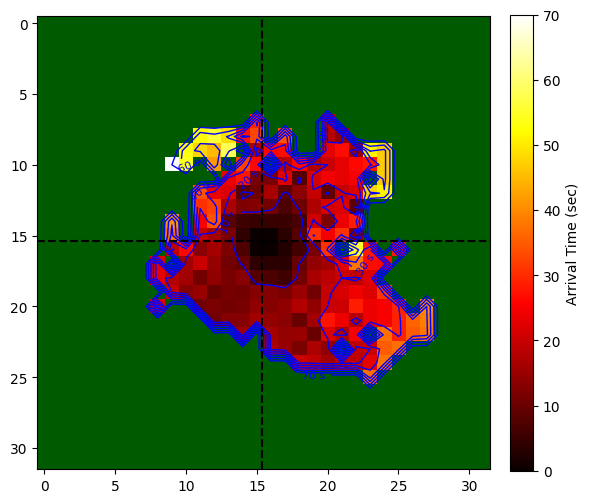

Average of selected matrices | Heat‑Map & Isochrones — 10s spacing


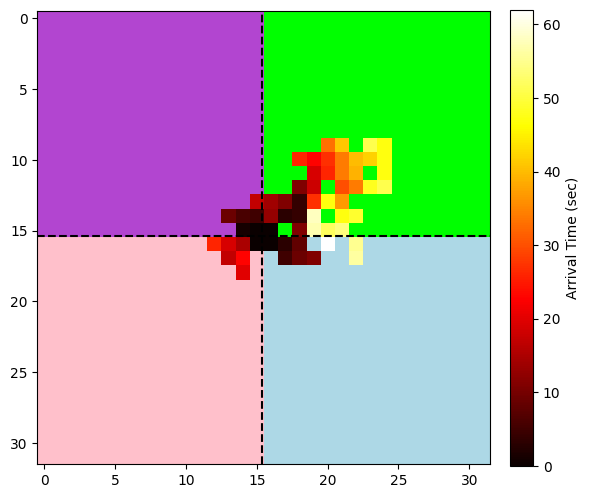

34 x 34--Green Wool = Leaves--v1 arrival | Heat‑Map


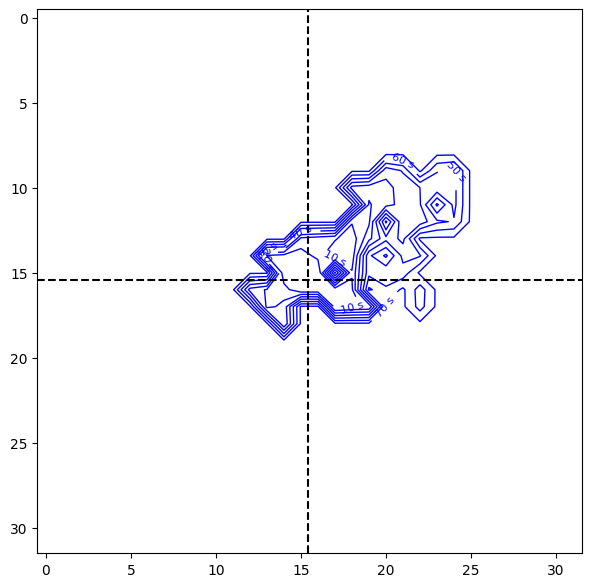

34 x 34--Green Wool = Leaves--v1 arrival | Isochrones — 10s spacing


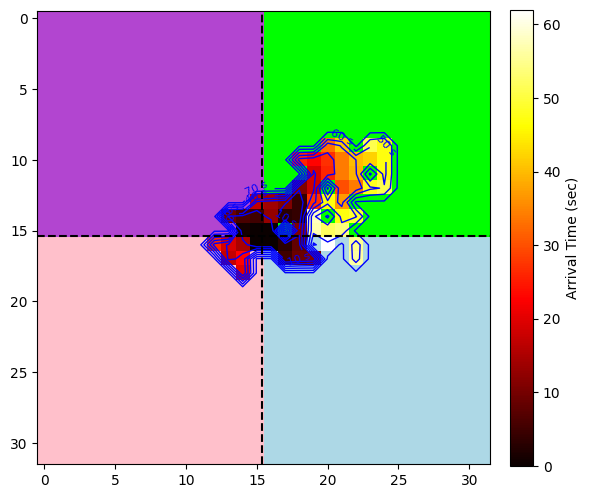

34 x 34--Green Wool = Leaves--v1 arrival | Heat‑Map & Isochrones — 10s spacing


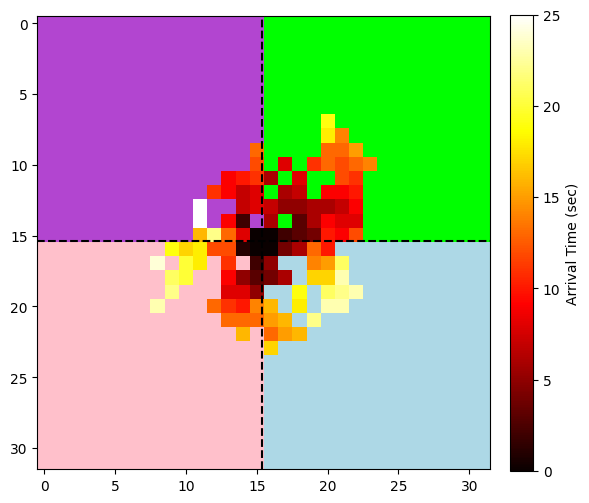

34 x 34--Green Wool = Leaves--v10 arrival | Heat‑Map


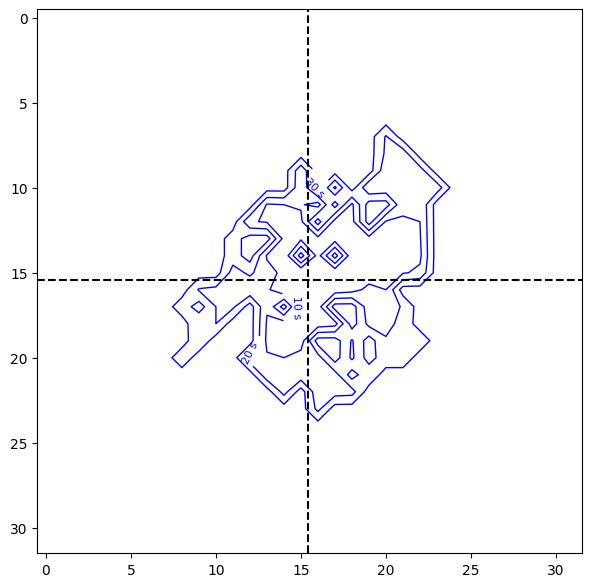

34 x 34--Green Wool = Leaves--v10 arrival | Isochrones — 10s spacing


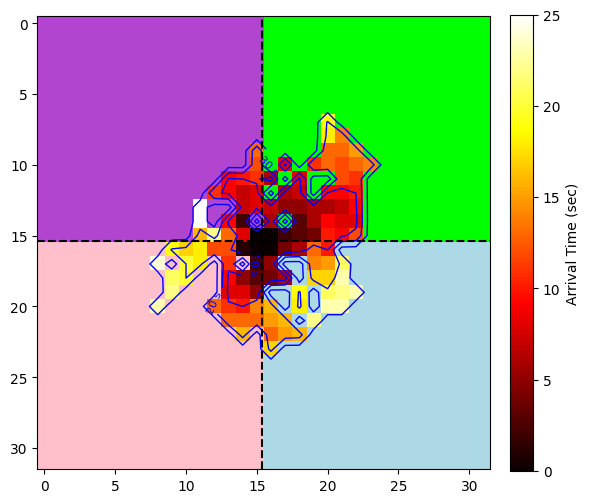

34 x 34--Green Wool = Leaves--v10 arrival | Heat‑Map & Isochrones — 10s spacing


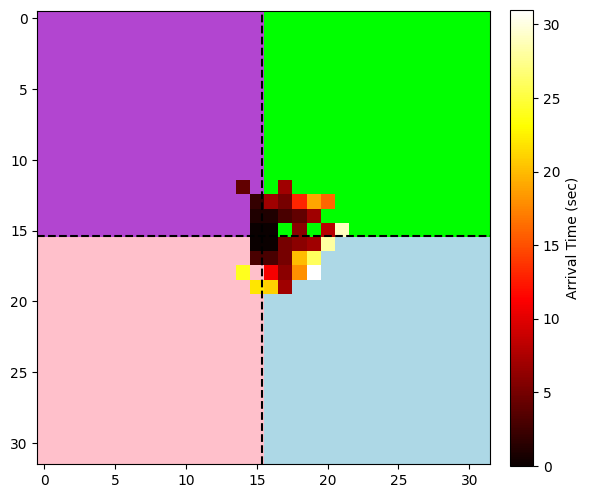

34 x 34--Green Wool = Leaves--v2 arrival | Heat‑Map


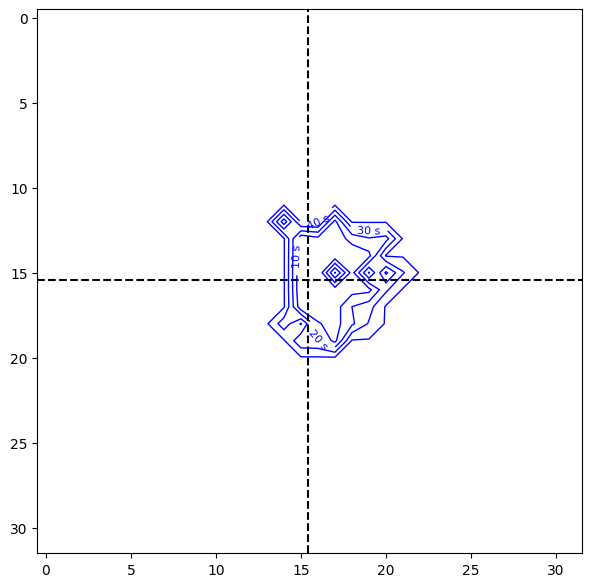

34 x 34--Green Wool = Leaves--v2 arrival | Isochrones — 10s spacing


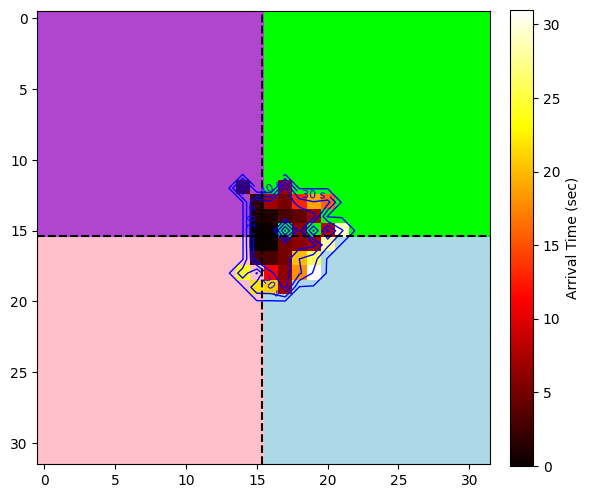

34 x 34--Green Wool = Leaves--v2 arrival | Heat‑Map & Isochrones — 10s spacing


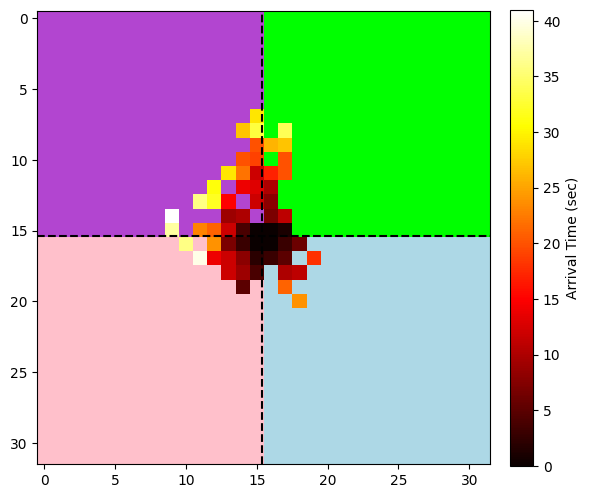

34 x 34--Green Wool = Leaves--v3 arrival | Heat‑Map


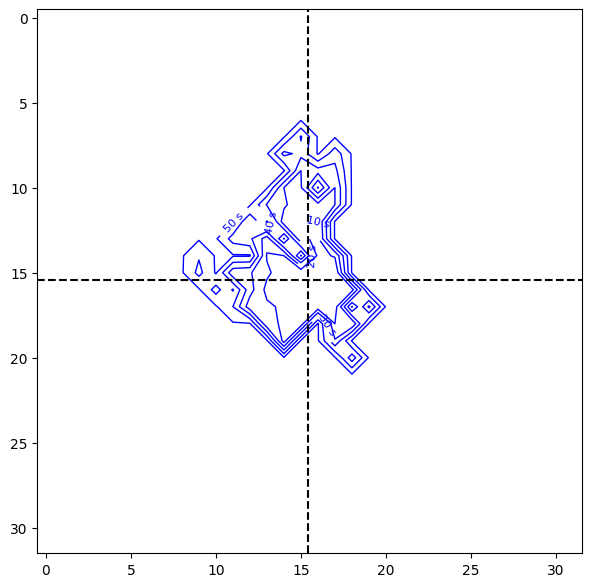

34 x 34--Green Wool = Leaves--v3 arrival | Isochrones — 10s spacing


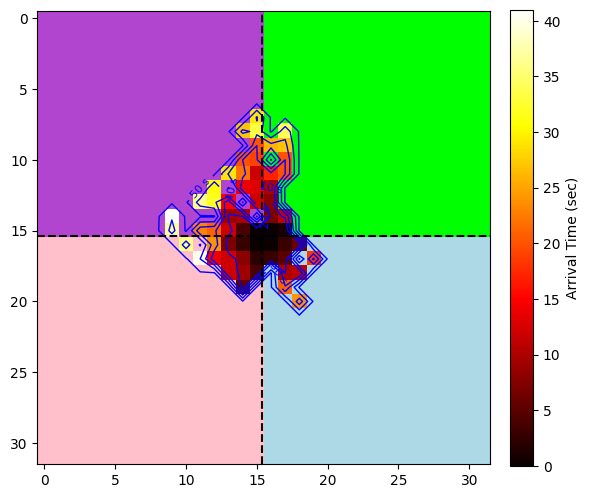

34 x 34--Green Wool = Leaves--v3 arrival | Heat‑Map & Isochrones — 10s spacing


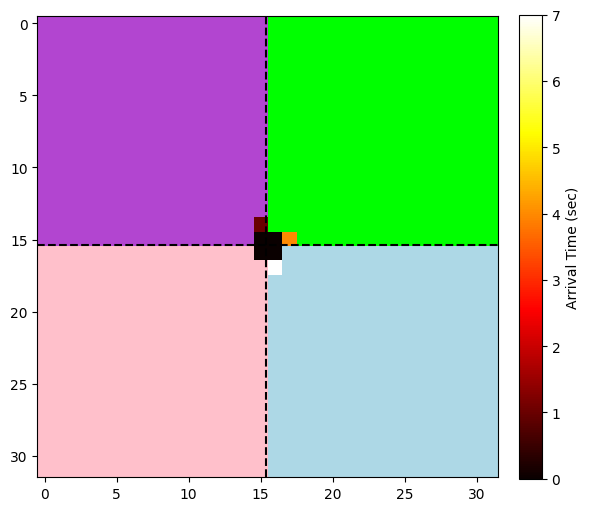

34 x 34--Green Wool = Leaves--v4 arrival | Heat‑Map


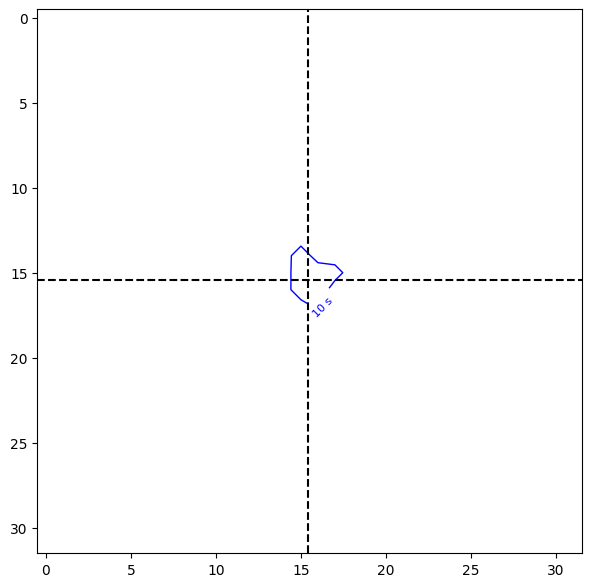

34 x 34--Green Wool = Leaves--v4 arrival | Isochrones — 10s spacing


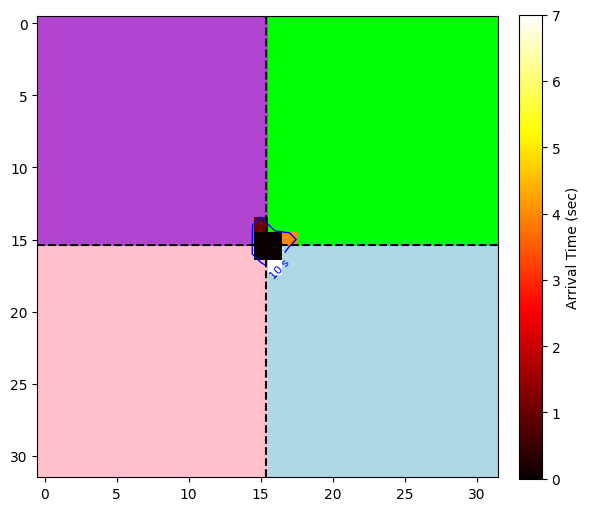

34 x 34--Green Wool = Leaves--v4 arrival | Heat‑Map & Isochrones — 10s spacing


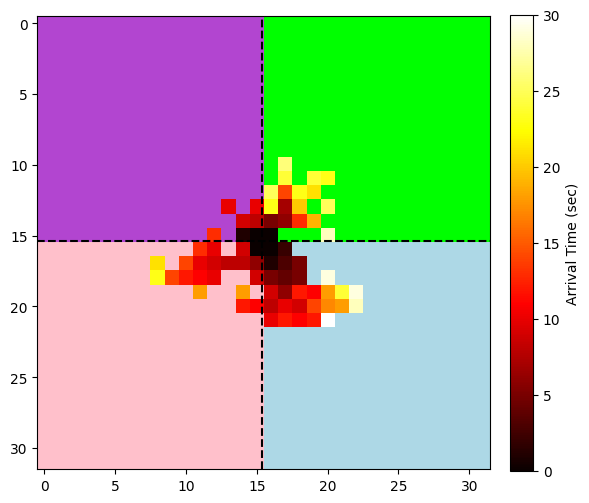

34 x 34--Green Wool = Leaves--v5 arrival | Heat‑Map


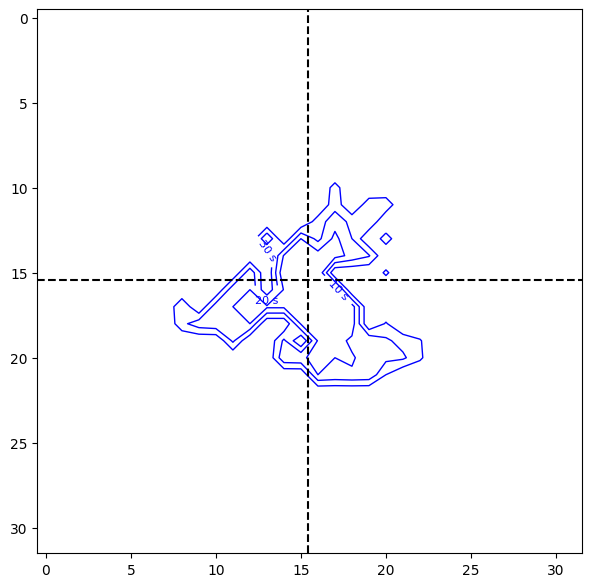

34 x 34--Green Wool = Leaves--v5 arrival | Isochrones — 10s spacing


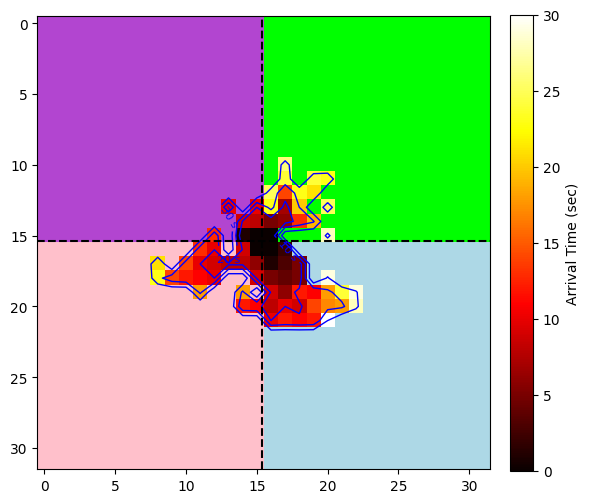

34 x 34--Green Wool = Leaves--v5 arrival | Heat‑Map & Isochrones — 10s spacing


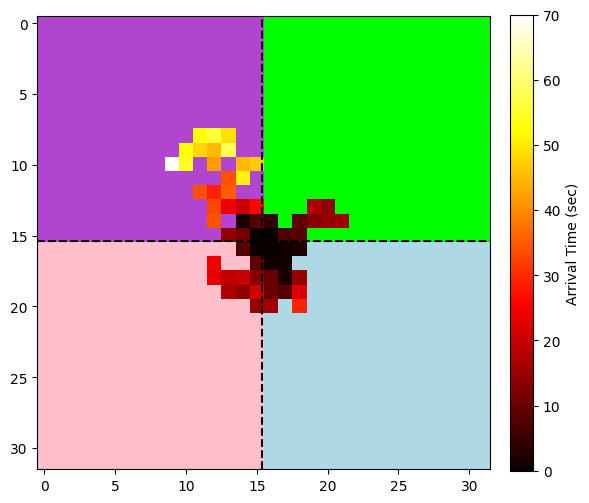

34 x 34--Green Wool = Leaves--v6 arrival | Heat‑Map


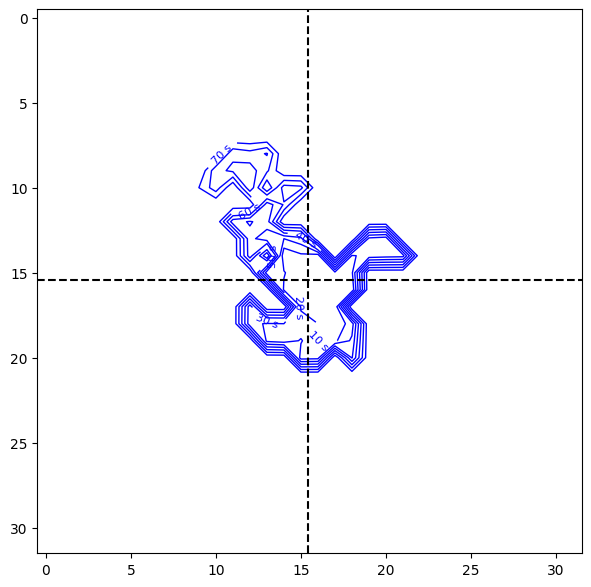

34 x 34--Green Wool = Leaves--v6 arrival | Isochrones — 10s spacing


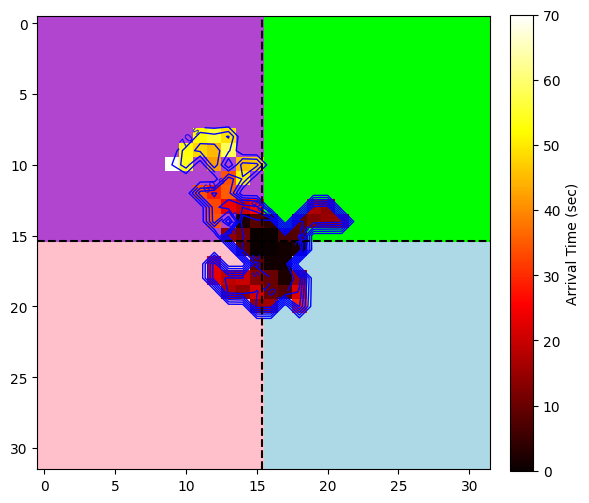

34 x 34--Green Wool = Leaves--v6 arrival | Heat‑Map & Isochrones — 10s spacing


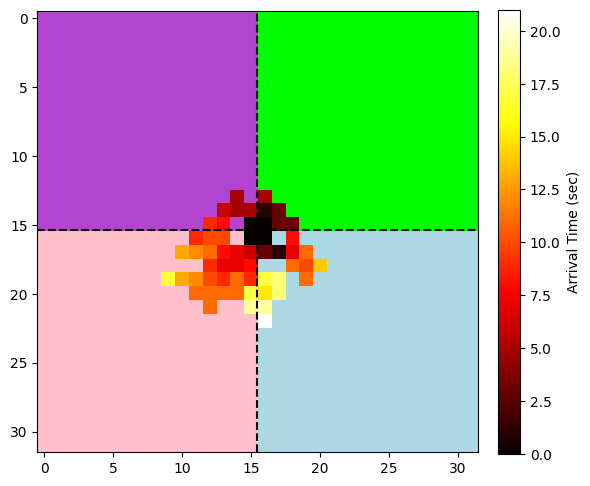

34 x 34--Green Wool = Leaves--v7 arrival | Heat‑Map


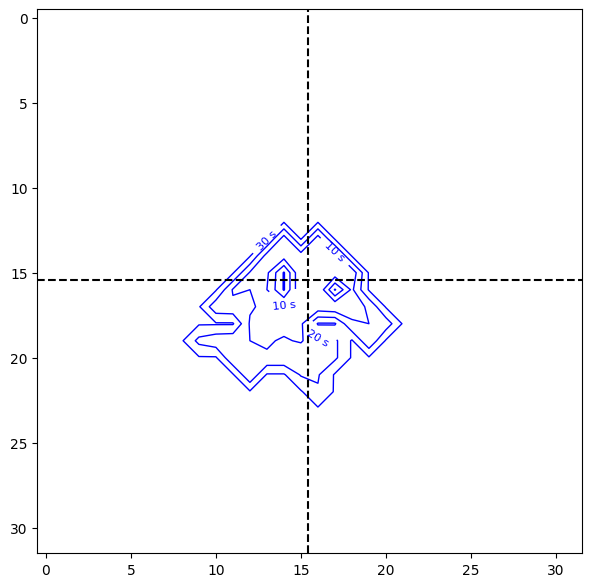

34 x 34--Green Wool = Leaves--v7 arrival | Isochrones — 10s spacing


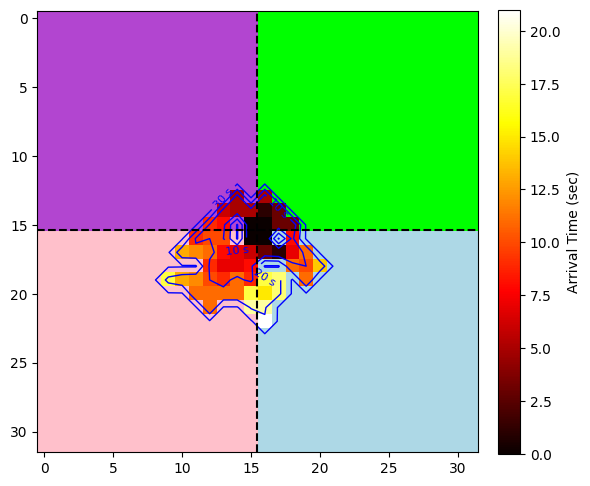

34 x 34--Green Wool = Leaves--v7 arrival | Heat‑Map & Isochrones — 10s spacing


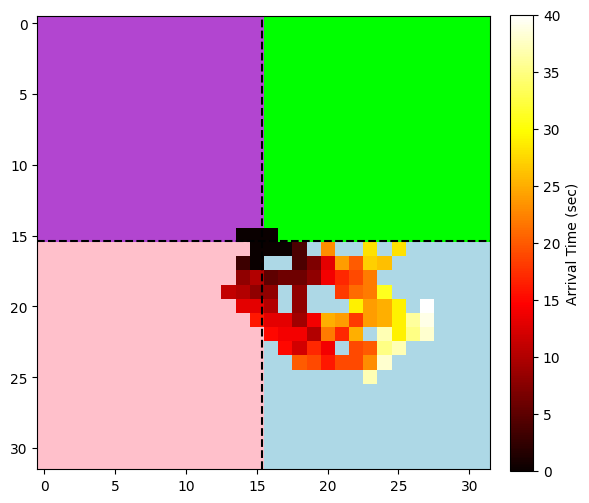

34 x 34--Green Wool = Leaves--v8 arrival | Heat‑Map


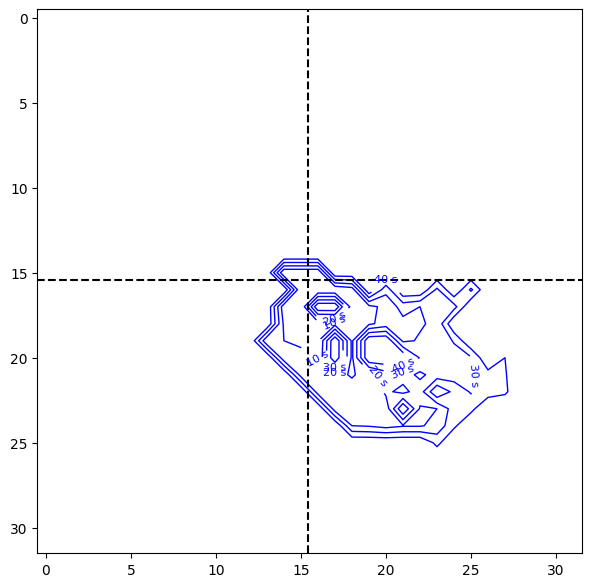

34 x 34--Green Wool = Leaves--v8 arrival | Isochrones — 10s spacing


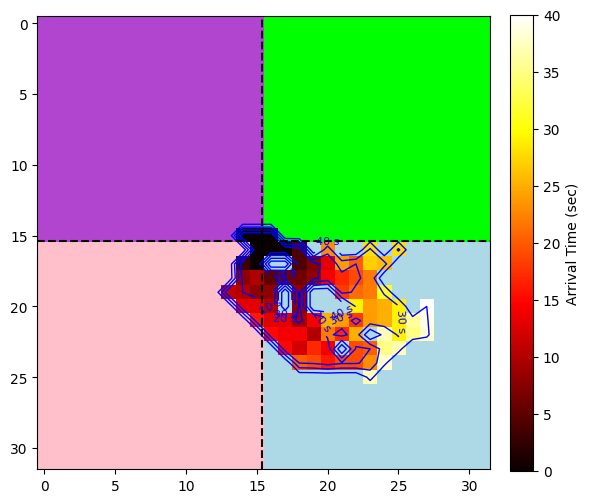

34 x 34--Green Wool = Leaves--v8 arrival | Heat‑Map & Isochrones — 10s spacing


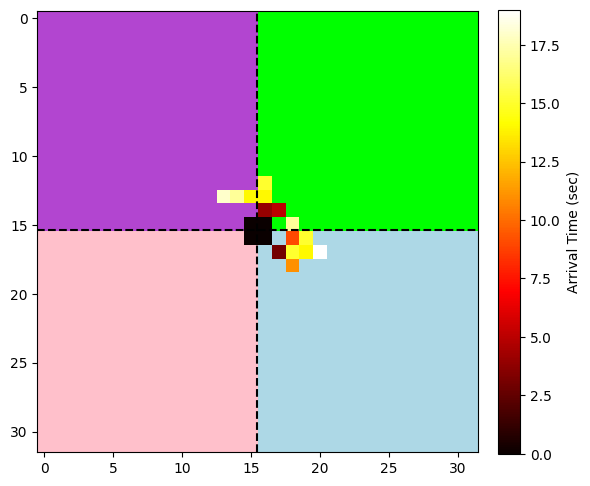

34 x 34--Green Wool = Leaves--v9 arrival | Heat‑Map


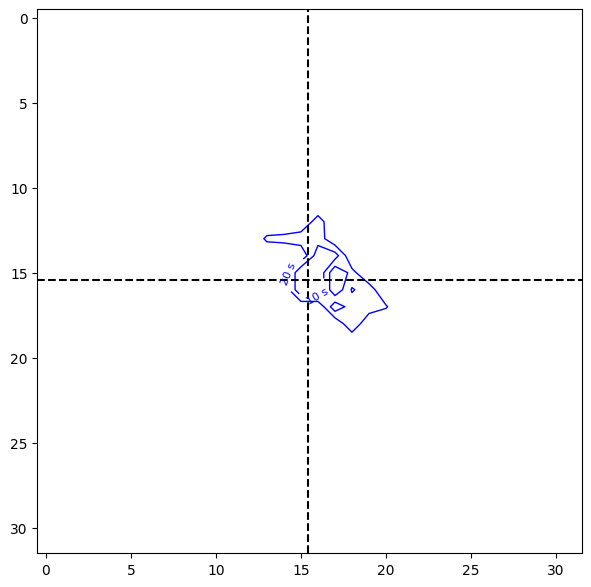

34 x 34--Green Wool = Leaves--v9 arrival | Isochrones — 10s spacing


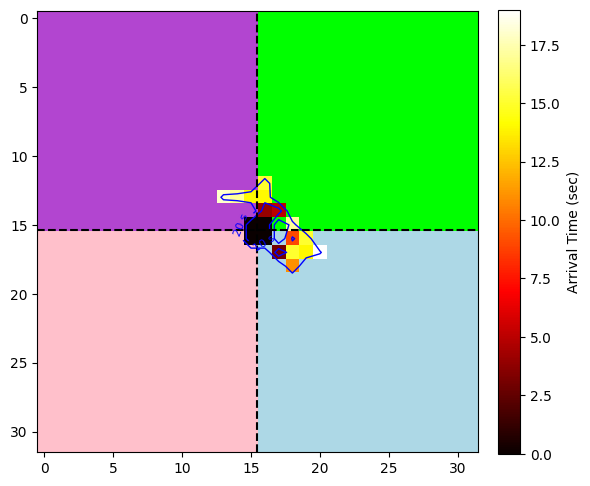

34 x 34--Green Wool = Leaves--v9 arrival | Heat‑Map & Isochrones — 10s spacing


In [6]:
# === Cell 3 : Process list, optional average, and plot =====================
loaded   = []
base_ids = []

for fname in MATRIX_FILES:
    path = ARRIVAL_DIR / fname  # absolute Path
    loaded.append(np.load(path))
    base_ids.append(Path(fname).stem)  # filename stem (no directories)

# ---------- average block --------------------------------------------------
if COMPUTE_AVERAGE and loaded:
    mean_mat = np.nanmean(np.stack(loaded, axis=0), axis=0)

    if SAVE_AVERAGE:
        first_stem = base_ids[0]                      # e.g. "34 x 34--Green …"
        prefix = re.sub(r"--v\d+\s+arrival$", "", first_stem)
        avg_fname = f"{prefix} average of {len(loaded)} arrival.npy"
        avg_path  = AVERAGE_OUTDIR / avg_fname
        # Ensure any intermediate dirs exist (unlikely after .stem, but safe)
        avg_path.parent.mkdir(parents=True, exist_ok=True)
        np.save(avg_path, mean_mat)
        print("💾 saved averaged matrix ->", avg_path)

    plot_arrival_heatmap_with_isochrones(
        mean_mat,
        unburnt_style="quadrants-1",
        show_heatmap=True,
        show_isochrones=True,
        caption=(f"{AVERAGE_NAME} | Heat‑Map & Isochrones — "
                 f"{TIME_INTERVAL}s spacing")
    )

# ---------- individual runs ------------------------------------------------
if SHOW_ORIGINALS:
    for mat, stem in zip(loaded, base_ids):
        nice_name = Path(stem).name
        # heat‑map only
        plot_arrival_heatmap_with_isochrones(
            mat,
            unburnt_style="quadrants-4",
            show_heatmap=True,
            show_isochrones=False,
            caption=f"{nice_name} | Heat‑Map"
        )
        # contours only
        plot_arrival_heatmap_with_isochrones(
            mat,
            unburnt_style="white",
            show_heatmap=False,
            show_isochrones=True,
            caption=f"{nice_name} | Isochrones — {TIME_INTERVAL}s spacing"
        )
        # combined
        plot_arrival_heatmap_with_isochrones(
            mat,
            unburnt_style="quadrants-4",
            show_heatmap=True,
            show_isochrones=True,
            caption=f"{nice_name} | Heat‑Map & Isochrones — {TIME_INTERVAL}s spacing"
        )
